# ETL (Extract-Transform-Load) Stage 

In this notebook I extract the data from both Narrowband and Wideband call recording sets, transform it into wideband or narrowband spectrograms and save it to be used as features to train and validate the deep CNN model. 

The POLQA scores which will be used as labels in the training and validation process are also extracted and stored in a csv alongside the filenames of the spectrograms we have generated.

In [6]:
import soundfile as sf   # We use this one to read and write sound file
import math # basic math functions
import io # We use this one for basic file input/output operations
import numpy as np   # We use this one to do numerical operations
import scipy.fftpack as fftpack # We use this one to perform Fourier transforms
import urllib.request as request  # We use this one to get things from the web
import matplotlib.pyplot as plt  # We use this one to plot things
# The next line causes matplotlib to put its plots in this webpage.  That's reasonable for small spectrograms, maybe less than one second.
%matplotlib inline

## Initialisation for NB Set creation
Here we choose a long sample from our dataset to act as an example and check its length. This is one of the outliers in the dataset.

In [2]:
filename = 'ajforesto4Christ-20120313-wgj_b0478_delay_100_jitter_1_plr_3_opus.wav'
p_data, p_fs = sf.read("C:\Honours_Project\degraded_dataset_NB\\"+filename)

In [83]:
len(p_data)/8000

18.06

This code will be used to trim the sample or pad them to give all of our samples a universal length of 10s. This is necessary to be a valid input for the neural network.

The last line checks that the file has in fact been trimmed

In [100]:
#try:
p_data=p_data[0:80000]
if(len(p_data)<80000):
    p_data = np.pad(p_data, (0,80000-len(p_data)), 'linear_ramp')
#except
len(p_data)/8000

10.0

## Initialisation for SWB Set Creation
The same process is followed for the twin sample in the SWB dataset

In [7]:
filename = 'ajforesto4Christ-20120313-wgj_b0478_plr3_opus.wav'
p_data, p_fs = sf.read("C:\Honours_Project\SWB_dataset_final\\"+filename)

In [8]:
len(p_data)/48000

18.625

In [9]:
#try:
p_data=p_data[0:480000]
if(len(p_data)<480000):
    p_data = np.pad(p_data, (0,480000-len(p_data)), 'linear_ramp')
#except
len(p_data)/48000

10.0

## Spectrogram Functions
The following functions will be used in the creation of both sets of spectrograms:

In [10]:
def enframe(x,S,L):
   # w = 0.54*np.ones(L)
    #for n in range(0,L):
     #   w[n] = w[n] - 0.46*math.cos(2*math.pi*n/(L-1))
    w = np.hamming(L)
    frames = []
    nframes = 1+int((len(x)-L)/S)
    for t in range(0,nframes):
        frames.append(np.copy(x[(t*S):(t*S+L)])*w)
    return(frames)

In [11]:
def stft(frames,N,Fs):
    stft_frames = [ fftpack.fft(x,N) for x in frames]
    freq_axis = np.linspace(0,Fs,N)
    return(stft_frames, freq_axis)

In [12]:
def stft2level(stft_spectra,max_freq_bin):
    magnitude_spectra = [ abs(x) for x in stft_spectra ]
    max_magnitude = max([ max(x) for x in magnitude_spectra ])
    min_magnitude = max_magnitude / 1000.0
    for t in range(0,len(magnitude_spectra)):
        for k in range(0,len(magnitude_spectra[t])):
            magnitude_spectra[t][k] /= min_magnitude
            if magnitude_spectra[t][k] < 1:
                magnitude_spectra[t][k] = 1
    level_spectra = [ 20*np.log10(x[0:max_freq_bin]) for x in magnitude_spectra ]
    return(level_spectra)

In [13]:
def sgram(x,frame_skip,frame_length,fft_length, fs, max_freq):
    frames = enframe(x,frame_skip,frame_length)
    (spectra, freq_axis) = stft(frames, fft_length, fs)
    sgram = stft2level(spectra, int(max_freq*fft_length/fs))
    max_time = len(frames)*frame_skip/fs
    return(sgram, max_time, max_freq)

These can be used to generate bother Wideband spectrograms or narrowband spectrograms depending on the parameters passed to them:

Text(0, 0.5, 'Frequency (Hz)')

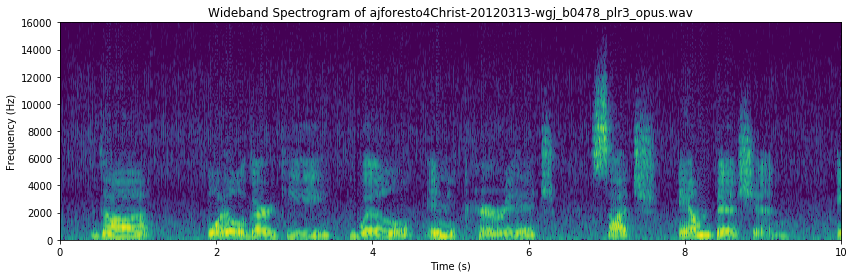

In [24]:
#Wideband Spec
p_wav=p_data
(p_sgram,p_maxtime, p_maxfreq) = sgram(p_wav, int(0.001*p_fs), int(0.004*p_fs), 1024, p_fs, 16000)
plt.figure(figsize=(14,4))
plt.imshow(np.transpose(np.array(p_sgram)),origin='lower',extent=(0,p_maxtime,0,p_maxfreq),aspect='auto')
plt.title('Wideband Spectrogram of '+filename)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

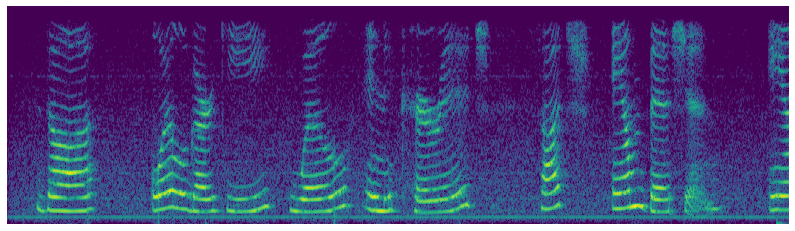

In [8]:
from matplotlib import ticker
#Narrowband Spec
p_wav=p_data
(p_sgram,p_maxtime, p_maxfreq) = sgram(p_wav[:80000], int(0.001*p_fs), int(0.035*p_fs), 1024, p_fs, 4000)
#fig,ax = plt.subplots(1)
#fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
#ax.axis('off')
#pxx, freqs, bins, im = ax.specgram(x=p_wav[], Fs=p_fs, noverlap=384, NFFT=1024)
#ax.axis('off')
#fig.savefig('sp_xyz.png', dpi=300, frameon='false')
plt.figure(figsize=(14,4))
plt.imshow(np.transpose(np.array(p_sgram)),origin='lower',extent=(0,p_maxtime,0,p_maxfreq),aspect='auto')
#plt.axis('off')
#plt.xaxis.set_major_locator(NullLocator())
#plt.yaxis.set_major_locator(NullLocator())
#plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
           # hspace = 0, wspace = 0)
#plt.margins(0,0)
plt.axis('off')
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_major_locator(ticker.NullLocator())
#plt.savefig('match.png', pad_inches=0, bbox_inches='tight', transparent=True)
plt.savefig("test.png", pad_inches=0, bbox_inches='tight', transparent='True')
#plt.title('Narrowband Spectrogram of '+filename)
#plt.xlabel('Time (s)')
#plt.ylabel('Frequency (Hz)')
#fig.savefig('sp_xyz.png', dpi=300, frameon='false'

The spectrogram could be saved in its raw form as a numpy array but this results in a huge filesize

In [37]:
sgramtest2wb=np.array(p_sgram)
print(sgramtest2wb.shape)
#print(sgramtest2.shape)
np.save('D:\sgramtest2.npy', sgramtest2wb)

(9966, 512)


## NB Spectrogram Generation
This function generates and saves the spectrograms for the NB call recording samples, parameters were adjusted to produce both WB and NB sets in turn. This was done at both high resolution (dpi=300) which could later be resized when the optimal level of quality was identified. This algorithm also kept track of missed files or errors that occured as well as POLQA_MOS scores for each sample. This was useful for investigation any problems when this stage began.

In [ ]:
import os
import h5py
from matplotlib import ticker
directory = 'C:\Honours_Project\degraded_dataset_NB'
spec_all_NB = []
#X_array = np.zeros([1000,9966,512])
filename_all_NB = []
#max_times_NB = []
#max_freq_NB = []
failed_files = []
Y_array = [] 
i=0

plt.figure(figsize=(14,4))
fig = plt.imshow(np.transpose(np.array(p_sgram)),origin='lower',extent=(0,p_maxtime,0,p_maxfreq),aspect='auto')
plt.axis('off')
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_major_locator(ticker.NullLocator())
for fname in os.listdir(directory):
    if fname.endswith(".wav"):
        #if (i==10):
         #   break
        #else:
            try:
                p_wav, p_fs = sf.read("C:\Honours_Project\degraded_dataset_NB\\"+fname)
            except RuntimeError:
                print ('File ' +fname+ 'could not be processed')
                failed_files.append(fname)
            else:
                p_wav=p_wav[0:80000]
                if(len(p_wav)<80000):
                    p_wav = np.pad(p_wav, (0,80000-len(p_wav)), 'linear_ramp')
                (p_sgram,p_maxtime, p_maxfreq) = sgram(p_wav, int(0.001*p_fs), int(0.035*p_fs), 1024, p_fs, 4000)
                '''plt.figure(figsize=(14,4))
                plt.imshow(np.transpose(np.array(p_sgram)),origin='lower',extent=(0,p_maxtime,0,p_maxfreq),aspect='auto')
                plt.title('Narrowband Spectrogram of '+filename)
                plt.xlabel('Time (s)')
                plt.ylabel('Frequency (Hz)')'''
                #spec_curr=np.array(p_sgram)
                #X_array[i]=spec_curr
                #plt.figure(figsize=(14,4))
                fig.set_data(np.transpose(np.array(p_sgram)))
                #plt.axis('off')
                #plt.xaxis.set_major_locator(NullLocator())
                #plt.yaxis.set_major_locator(NullLocator())
                #plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                                       # hspace = 0, wspace = 0)
                #plt.margins(0,0)
                
                #plt.savefig('match.png', pad_inches=0, bbox_inches='tight', transparent=True)
                plt.savefig("D:\Spectrograms\\"+fname[0:-4]+".png", pad_inches=0, bbox_inches='tight', dpi=300, transparent='True')
                Y_array.append(POLQA_MOS[i+len(failed_files)])
                #spec_curr=np.array(p_sgram)
                #np.save('spectrograms\\'+filename[0:-4]+'.npy',spec_curr)
               # with h5py.File('spectrograms\spec_nb.h5', 'a') as hf:
               #      hf.create_dataset(filename[0:-4], data=p_sgram)
                filename_all_NB.append(fname)
                #plt.close()
                #plt.clf()
               # max_times_NB.append(p_maxtime)
               # max_freq_NB.append(p_maxfreq)
                i+=1
        

## SWB Spectrogram Generation

The same process was used for the SWB call samples to generate both NB and WB spectrograms.

In [ ]:
import os
import h5py
from matplotlib import ticker
directory = 'C:\Honours_Project\swb_dataset_final'
spec_all_NB = []
#X_array = np.zeros([1000,9966,512])
filename_all_NB = []
#max_times_NB = []
#max_freq_NB = []
failed_files = []
#Y_array = [] 
i=0

plt.figure(figsize=(14,4))
fig = plt.imshow(np.transpose(np.array(p_sgram)),origin='lower',extent=(0,p_maxtime,0,p_maxfreq),aspect='auto')
plt.axis('off')
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_major_locator(ticker.NullLocator())
for fname in os.listdir(directory):
    if fname.endswith(".wav"):
        #if (i==10):
         #   break
        #else:
            try:
                p_wav, p_fs = sf.read("C:\Honours_Project\swb_dataset_final\\"+fname)
            except RuntimeError:
                print ('File ' +fname+ 'could not be processed')
                failed_files.append(fname)
            else:
                p_wav=p_wav[0:480000]
                if(len(p_wav)<480000):
                    p_wav = np.pad(p_wav, (0,480000-len(p_wav)), 'linear_ramp')
                (p_sgram,p_maxtime, p_maxfreq) = sgram(p_wav, int(0.001*p_fs), int(0.004*p_fs), 1024, p_fs, 16000)
                '''plt.figure(figsize=(14,4))
                plt.imshow(np.transpose(np.array(p_sgram)),origin='lower',extent=(0,p_maxtime,0,p_maxfreq),aspect='auto')
                plt.title('Narrowband Spectrogram of '+filename)
                plt.xlabel('Time (s)')
                plt.ylabel('Frequency (Hz)')'''
                #spec_curr=np.array(p_sgram)
                #X_array[i]=spec_curr
                #plt.figure(figsize=(14,4))
                fig.set_data(np.transpose(np.array(p_sgram)))
                #plt.axis('off')
                #plt.xaxis.set_major_locator(NullLocator())
                #plt.yaxis.set_major_locator(NullLocator())
                #plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                                       # hspace = 0, wspace = 0)
                #plt.margins(0,0)
                
                #plt.savefig('match.png', pad_inches=0, bbox_inches='tight', transparent=True)
                plt.savefig("D:\Spectrograms\SWB\\"+fname[0:-4]+".png", dpi=300, pad_inches=0, bbox_inches='tight', transparent='True')
                #Y_array.append(POLQA_MOS[i+len(failed_files)])
                #spec_curr=np.array(p_sgram)
                #np.save('spectrograms\\'+filename[0:-4]+'.npy',spec_curr)
               # with h5py.File('spectrograms\spec_nb.h5', 'a') as hf:
               #      hf.create_dataset(filename[0:-4], data=p_sgram)
                filename_all_NB.append(fname)
                #plt.close()
                #plt.clf()
               # max_times_NB.append(p_maxtime)
               # max_freq_NB.append(p_maxfreq)
                i+=1
        

## Creating the Dataframe
The next steps create a datafram storing the filenames of the generated spectrograms against the POLQA MOS values from the respective audio sample. The example below shows the process for the SWB dataset - an identical process was used for the NB dataset

In [9]:
import pandas as pd

df_nb = pd.read_csv("/Honours_Project/Polqa_results/Results_POLQA_NB_v3.csv")
df_nb['Degraded'].head(5)

POLQA_MOS = df_nb['MOS']

In [7]:
import pandas as pd

df_swb = pd.read_csv("/Honours_Project/Polqa_results/Results_POLQA_SWB_extracted.csv")
df_swb['Degraded'].head(5)

POLQA_MOS = df_swb['MOS']

In [8]:
dffswb = df_swb['Degraded']

In [ ]:
POLQA_scores_swb=df_swb[['Degraded','MOS']]
POLQA_scores_swb

In [42]:
#trim the path from the filename
POLQA_fname_full=(df['Degraded'].astype(str))
polqa_fname = [x[39:] for x in POLQA_fname_full]

In [10]:
#ensure we can see the full path when displayed
pd.set_option('display.max_colwidth', -1)

In [19]:
dfswb2=df_swb[['Degraded','MOS']]

In [22]:
#trim the filename and add the .png format suffix
dfswb2.Spectrograms=dfswb2.Spectrograms.str[37:-3]+'png'

In [21]:
#rename the columns to reflect new data
dfswb2.rename(columns={'Degraded':'Spectrograms'}, 
                 inplace=True)

In [25]:
#save the dataframe 
df3.to_csv('specswbfull2.csv', sep='\t', encoding='utf-8', index=False)

In [24]:
#drop any values which are not a number 'NAN' - these would be samples which caused errors during the POLQA evaluation
df3 = dfswb2.dropna()

In [3]:
#read the saved df
df3 = pd.read_csv('specswbfull2.csv', sep='\t')

In [4]:
#display the first 5 entires
df3.head(5)

,Spectrograms,MOS
0,1028-20100710-hne_ar-01_plr1_opus.png,3.88
1,1028-20100710-hne_ar-02_plr3_evs.png,4.21
2,1028-20100710-hne_ar-03_plr5_opus.png,4.10
3,1028-20100710-hne_ar-04_plr1_evs.png,4.63
4,1028-20100710-hne_ar-05_plr3_opus.png,4.44
